In [1]:
# import torch functions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

# import torchvision functions
import torchvision
from torchvision.models import vgg16
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
import torchvision.transforms as T

# import other functions
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from itertools import islice
from PIL import Image
import time 
import torchsummary

In [2]:
original_dataset_dir = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection'

In [3]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [4]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [4]:
# fonction pour entrainer les modeles

def fit(model, train_loader, val_loader, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        start_time = time.time()
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Entraîne le modèle sur un lot de données
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #running_loss += loss.item()
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            running_loss += loss.item()
        
            if (i+1) % steps_per_epoch == 0:
                break
        train_loss = running_loss / steps_per_epoch
        train_acc = accuracy / steps_per_epoch 
                
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(val_loader):
                outputs = model(images)
                val_loss += criterion(outputs, labels.float().view(-1,1)).item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
                
                if i >= validation_steps:
                    break
        
        val_loss /= validation_steps
        val_acc /= validation_steps 

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time:.4f}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
tomnod_1_50epochs = CNN()   

In [7]:
torchsummary.summary(tomnod_1_50epochs, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [8]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(tomnod_1_50epochs.parameters(), lr=0.0001)

In [9]:
datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #transforms.Normalize((0,), (1/255,))
])

train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=datagen)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=datagen)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)


In [10]:
print('Found {} images belonging to {} classes.'.format(len(train_dataset), len(train_dataset.classes)))
print('Found {} images belonging to {} classes.'.format(len(val_dataset), len(val_dataset.classes)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 50
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_1_50epochs, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

91.13857984542847
Epoch [1/50], Time : 91.1386, Train Loss: 0.4974, Train Accuracy: 0.6560, Validation Loss: 0.4298, Validation Accuracy: 0.8510
88.49040794372559
Epoch [2/50], Time : 88.4904, Train Loss: 0.4052, Train Accuracy: 0.8455, Validation Loss: 0.2999, Validation Accuracy: 0.8950
88.80665922164917
Epoch [3/50], Time : 88.8067, Train Loss: 0.2355, Train Accuracy: 0.8835, Validation Loss: 0.2307, Validation Accuracy: 0.9270
89.12503147125244
Epoch [4/50], Time : 89.1250, Train Loss: 0.2867, Train Accuracy: 0.8870, Validation Loss: 0.2268, Validation Accuracy: 0.9220
90.15391755104065
Epoch [5/50], Time : 90.1539, Train Loss: 0.2670, Train Accuracy: 0.9100, Validation Loss: 0.2246, Validation Accuracy: 0.9220
88.80735301971436
Epoch [6/50], Time : 88.8074, Train Loss: 0.1891, Train Accuracy: 0.8935, Validation Loss: 0.2109, Validation Accuracy: 0.9280
88.73658728599548
Epoch [7/50], Time : 88.7366, Train Loss: 0.0977, Train Accuracy: 0.8900, Validation Loss: 0.1972, Validation Ac

In [12]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_1_50epochs.state_dict(), path_save+"/tomnod_1_50epochs.pth")

#tomnod_1_50epochs = CNN()
#tomnod_1_50epochs.load_state_dict(torch.load(path_save+"tomnod_1_50epochs.pth"))
#torchsummary.summary(tomnod_1_50epochs, (3,150,150))

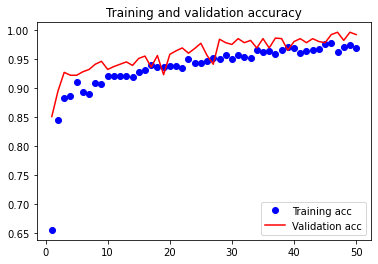

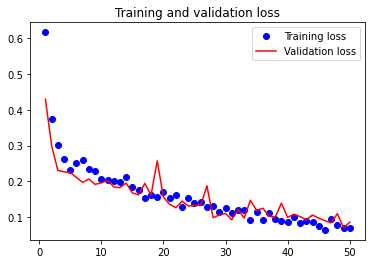

In [13]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = self.dropout(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
tomnod_2_100epochs = CNN2()

In [15]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(tomnod_2_100epochs.parameters(), lr=0.0001)

In [16]:
train_datagen  = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomRotation(40),
    transforms.RandomCrop(150),
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip()
])

test_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=test_datagen)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [17]:
print('Found {} images belonging to {} classes.'.format(len(train_dataset), len(train_dataset.classes)))
print('Found {} images belonging to {} classes.'.format(len(val_dataset), len(val_dataset.classes)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 100
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_2_100epochs, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

154.93123269081116
Epoch [1/100], Time : 154.9312, Train Loss: 0.4489, Train Accuracy: 0.6497, Validation Loss: 0.4631, Validation Accuracy: 0.8219
154.81652069091797
Epoch [2/100], Time : 154.8165, Train Loss: 0.5315, Train Accuracy: 0.7628, Validation Loss: 0.4399, Validation Accuracy: 0.8094
157.1261658668518
Epoch [3/100], Time : 157.1262, Train Loss: 0.3995, Train Accuracy: 0.8091, Validation Loss: 0.3723, Validation Accuracy: 0.8612
155.78436470031738
Epoch [4/100], Time : 155.7844, Train Loss: 0.5558, Train Accuracy: 0.8256, Validation Loss: 0.3975, Validation Accuracy: 0.8387
159.26687121391296
Epoch [5/100], Time : 159.2669, Train Loss: 0.4396, Train Accuracy: 0.8431, Validation Loss: 0.2508, Validation Accuracy: 0.9231
162.8892104625702
Epoch [6/100], Time : 162.8892, Train Loss: 0.4122, Train Accuracy: 0.8500, Validation Loss: 0.3765, Validation Accuracy: 0.8512
162.4579770565033
Epoch [7/100], Time : 162.4580, Train Loss: 0.3712, Train Accuracy: 0.8522, Validation Loss: 0.2

150.70652723312378
Epoch [57/100], Time : 150.7065, Train Loss: 0.2807, Train Accuracy: 0.9209, Validation Loss: 0.1241, Validation Accuracy: 0.9738
150.7548110485077
Epoch [58/100], Time : 150.7548, Train Loss: 0.2330, Train Accuracy: 0.9219, Validation Loss: 0.2303, Validation Accuracy: 0.9325
150.69633102416992
Epoch [59/100], Time : 150.6963, Train Loss: 0.1628, Train Accuracy: 0.9172, Validation Loss: 0.1762, Validation Accuracy: 0.9556
149.92777848243713
Epoch [60/100], Time : 149.9278, Train Loss: 0.1440, Train Accuracy: 0.9194, Validation Loss: 0.1484, Validation Accuracy: 0.9637
150.21655797958374
Epoch [61/100], Time : 150.2166, Train Loss: 0.1520, Train Accuracy: 0.9241, Validation Loss: 0.1434, Validation Accuracy: 0.9637
150.06980514526367
Epoch [62/100], Time : 150.0698, Train Loss: 0.1226, Train Accuracy: 0.9213, Validation Loss: 0.1194, Validation Accuracy: 0.9762
151.30023908615112
Epoch [63/100], Time : 151.3002, Train Loss: 0.1394, Train Accuracy: 0.9269, Validation 

In [19]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_2_100epochs.state_dict(), path_save+"/tomnod_2_100epochs.pth")

#tomnod_2_100epochs = CNN2()
#tomnod_2_100epochs.load_state_dict(torch.load(path_save+"tomnod_2_100epochs.pth"))
#torchsummary.summary(tomnod_2_100epochs, (3,150,150))

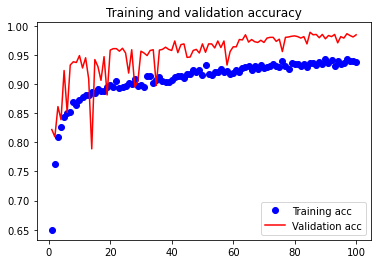

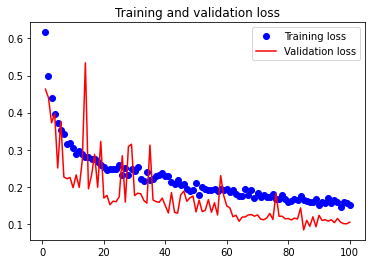

In [20]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Adam optimizer

In [21]:
tomnod_2_100epochs_Adam = CNN2()

In [22]:
criterion = nn.BCELoss()
optimizer = optim.Adam(tomnod_2_100epochs_Adam.parameters(), lr=0.0001)

In [23]:
train_datagen  = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomRotation(40),
    transforms.RandomCrop(150),
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip()
])

test_datagen = transforms.Compose([
    transforms.Resize((150, 150)), #transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #transforms.Normalize((0,), (1/255,)),
])


train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=test_datagen)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [24]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 100
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_2_100epochs_Adam, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

155.3001856803894
Epoch [1/100], Time : 155.3002, Train Loss: 0.5993, Train Accuracy: 0.6094, Validation Loss: 0.5742, Validation Accuracy: 0.7087
154.28676056861877
Epoch [2/100], Time : 154.2868, Train Loss: 0.4600, Train Accuracy: 0.7544, Validation Loss: 0.3818, Validation Accuracy: 0.8856
155.80055117607117
Epoch [3/100], Time : 155.8006, Train Loss: 0.3764, Train Accuracy: 0.7969, Validation Loss: 0.5005, Validation Accuracy: 0.7500
155.69371008872986
Epoch [4/100], Time : 155.6937, Train Loss: 0.4885, Train Accuracy: 0.7891, Validation Loss: 0.4877, Validation Accuracy: 0.7612
158.1698637008667
Epoch [5/100], Time : 158.1699, Train Loss: 0.3404, Train Accuracy: 0.8334, Validation Loss: 0.3131, Validation Accuracy: 0.8975
158.42997431755066
Epoch [6/100], Time : 158.4300, Train Loss: 0.3242, Train Accuracy: 0.8478, Validation Loss: 0.2670, Validation Accuracy: 0.9231
160.6112449169159
Epoch [7/100], Time : 160.6112, Train Loss: 0.2925, Train Accuracy: 0.8566, Validation Loss: 0.3

161.15284156799316
Epoch [57/100], Time : 161.1528, Train Loss: 0.1424, Train Accuracy: 0.9269, Validation Loss: 0.1589, Validation Accuracy: 0.9581
163.37661981582642
Epoch [58/100], Time : 163.3766, Train Loss: 0.1868, Train Accuracy: 0.9253, Validation Loss: 0.1099, Validation Accuracy: 0.9769
160.890150308609
Epoch [59/100], Time : 160.8902, Train Loss: 0.1196, Train Accuracy: 0.9259, Validation Loss: 0.1297, Validation Accuracy: 0.9706
165.38489294052124
Epoch [60/100], Time : 165.3849, Train Loss: 0.2493, Train Accuracy: 0.9075, Validation Loss: 0.1634, Validation Accuracy: 0.9581
163.17717051506042
Epoch [61/100], Time : 163.1772, Train Loss: 0.2174, Train Accuracy: 0.9150, Validation Loss: 0.1257, Validation Accuracy: 0.9719
162.87007665634155
Epoch [62/100], Time : 162.8701, Train Loss: 0.3913, Train Accuracy: 0.9147, Validation Loss: 0.1624, Validation Accuracy: 0.9569
163.7634632587433
Epoch [63/100], Time : 163.7635, Train Loss: 0.2015, Train Accuracy: 0.9194, Validation Lo

In [25]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_2_100epochs_Adam.state_dict(), path_save+"/tomnod_2_100epochs_Adam.pth")

#tomnod_2_100epochs_Adam = CNN2()
#tomnod_2_100epochs_Adam.load_state_dict(torch.load(path_save+"/tomnod_2_100epochs_Adam.pth"))
#torchsummary.summary(tomnod_2_100epochs_Adam, (3,150,150))

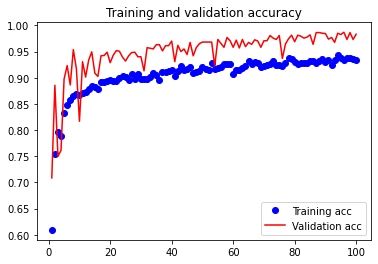

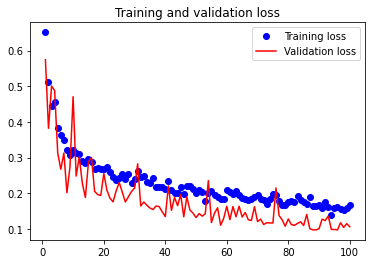

In [26]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
img_path = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/damage/-96.960704_28.783292.jpeg'

img = Image.open(img_path)
img = img.resize((150,150))
img_tensor = np.array(img)
img_tensor = img_tensor.transpose((2, 0, 1))
img_tensor = img_tensor[np.newaxis, :]
img_tensor = img_tensor.astype('float32') / 255.

print(img_tensor.shape)

(1, 3, 150, 150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


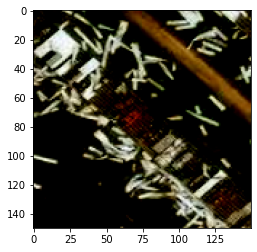

In [29]:
transform = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)

# visualizing the tensor
plt.imshow(img_tensor[0].permute(1, 2, 0))
plt.show()


In [30]:
def get_activations(model, input_data):
    activations = []
    activations.append(input_data)
    for i, layer in enumerate(model):
        activations.append(layer(activations[i]))
    return activations

In [31]:
layer_outputs = []
layer_names = []
# Boucle sur les 8 premières couches du modèle
for i, module in enumerate(list(model.children())[:8]):
    layer_outputs.append(module)
    layer_names.append(f"Layer {i}")

# Appeler la fonction pour obtenir les activations des 8 premières couches
activations = get_activations(layer_outputs, img_tensor)

# Définir le nombre d'images par ligne
images_per_row = 16


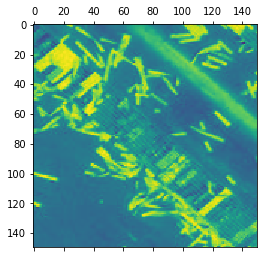

In [32]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0][0, :, :], cmap='viridis')


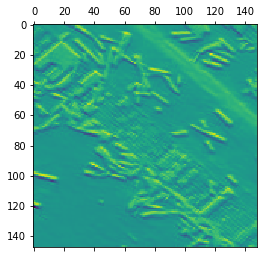

In [33]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0][0, :, :].detach().numpy(),cmap = 'viridis')


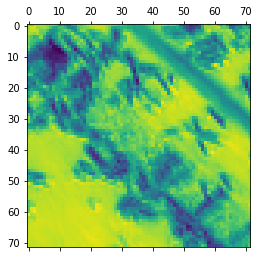

In [34]:
third_layer_activation = activations[3]
plt.matshow(third_layer_activation[0][0, :, :].detach().numpy(), cmap='viridis')


C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\matplotlib\tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\matplotlib\tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\matplotlib\patches.py:750: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\matplotlib\transforms.py:2053: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


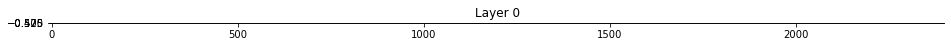

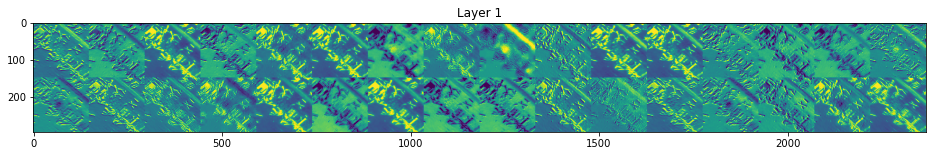

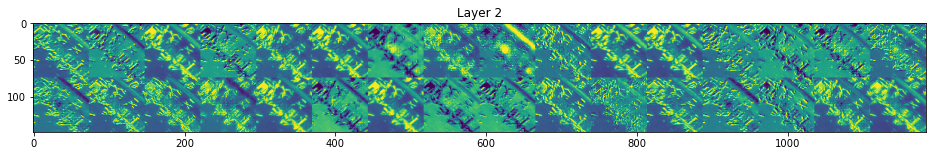

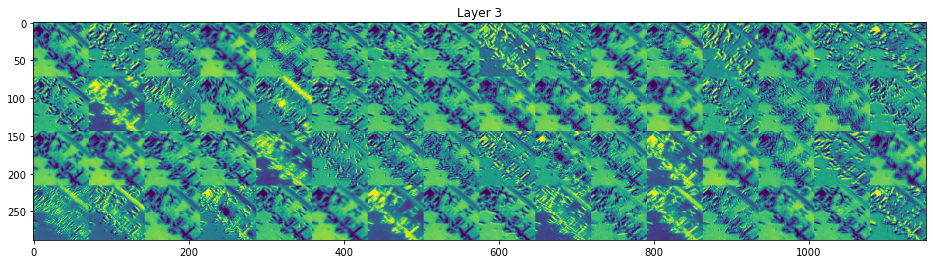

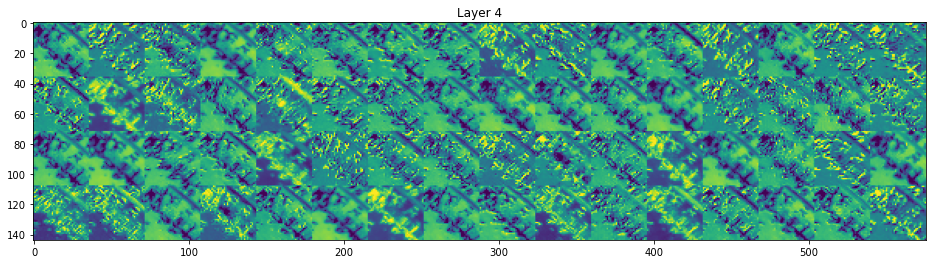

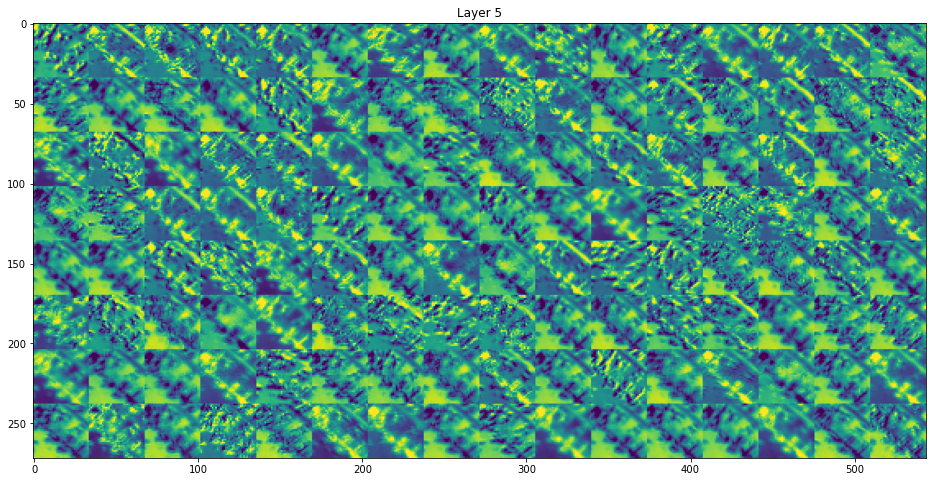

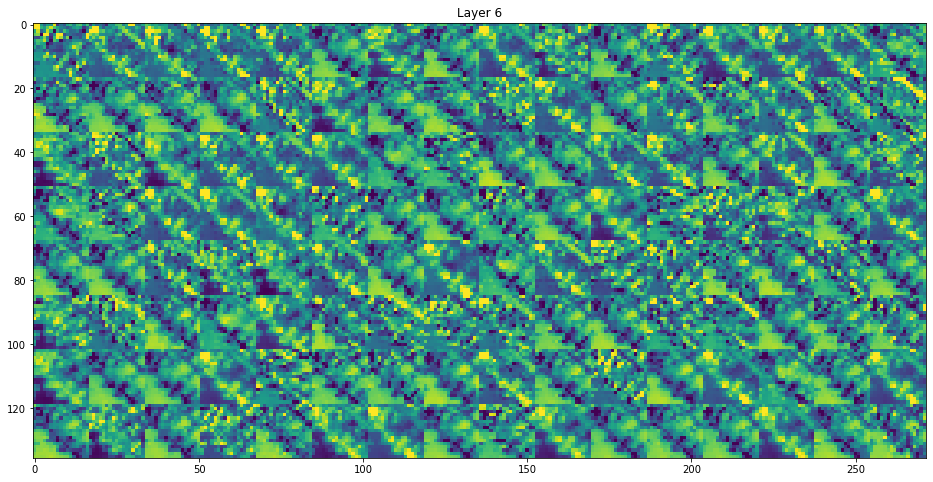

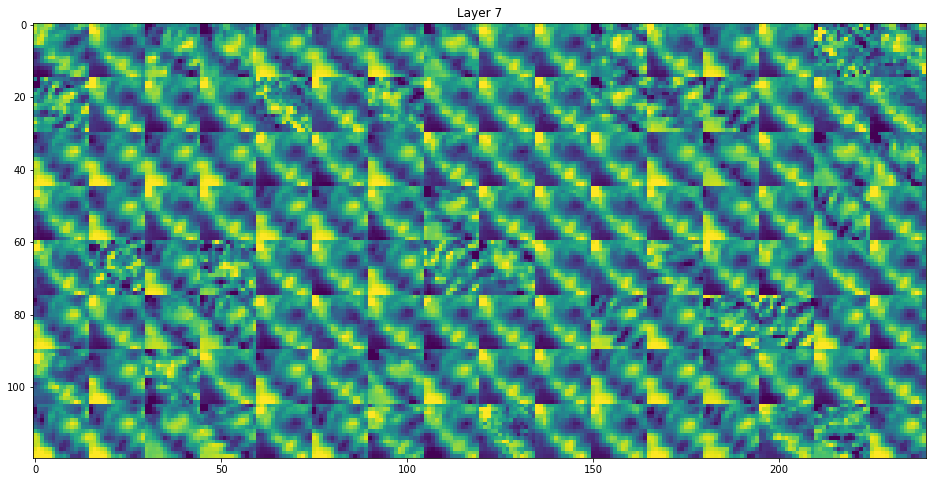

In [35]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[1]
    size = layer_activation.shape[2]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size))
    layer_activation = layer_activation.detach().numpy()
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, col*images_per_row + row, :, :]
            #channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    